**Assignment 3- Part c3**



**Using pure tensorflow keras with high level primitives to build neural network**

In [9]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras import optimizers
import tensorflow as tf

In [10]:
n = 200
input_dim = 3
output_dim = 2

x = tf.Variable(tf.random.uniform(shape=(n, input_dim)))
weights_true = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
bias_true = tf.Variable(tf.zeros(shape=(output_dim,)))

y = tf.matmul(tf.pow(x,2), weights_true) + tf.matmul(x, weights_true) + bias_true

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y.shape}')

x: (200, 3), weights: (3, 2), bias: (2,), y: (200, 2)


Defining model with linear dropout and Relu layer

In [11]:
def predictions(x, weights, bias):
    return tf.matmul(tf.pow(x,2), weights) + tf.matmul(x, weights) + bias

class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

class MLPWithDropout(Layer):

  def __init__(self):
      super(MLPWithDropout, self).__init__()
      self.linear_1 = Linear(20)
      self.dropout = Dropout(0.2)
      self.linear_3 = Linear(2)

  def call(self, inputs, training=None):
      x = self.linear_1(inputs)
      x = tf.nn.relu(x)
      x = self.dropout(x, training=training)
      x = tf.nn.relu(x)
      return self.linear_3(x)

In [12]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

Using Gradient Tape for calculating gradients

In [13]:
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = mlp(x)
    loss = tf.keras.losses.MSE(y, predictions)
    gradients = tape.gradient(loss, mlp.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

  return predictions, loss

# Shuffle the data.
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=100).batch(100)

mlp = MLPWithDropout()

for epoch in range(8000):
  for step, (x_t, y_t) in enumerate(dataset):
    y_pred, loss = train_on_batch(x_t, y_t)
  if epoch % 500 ==0:
    print('Epoch %d: last batch loss = %.4f' % (epoch, float(tf.reduce_sum(loss))))

Epoch 0: last batch loss = 145.7359
Epoch 500: last batch loss = 0.3855
Epoch 1000: last batch loss = 0.2863
Epoch 1500: last batch loss = 0.2052
Epoch 2000: last batch loss = 0.1629
Epoch 2500: last batch loss = 0.1316
Epoch 3000: last batch loss = 0.0769
Epoch 3500: last batch loss = 0.0510
Epoch 4000: last batch loss = 0.0404
Epoch 4500: last batch loss = 0.0385
Epoch 5000: last batch loss = 0.0382
Epoch 5500: last batch loss = 0.0402
Epoch 6000: last batch loss = 0.0345
Epoch 6500: last batch loss = 0.0351
Epoch 7000: last batch loss = 0.0369
Epoch 7500: last batch loss = 0.0360


In [14]:
y_pred = mlp(x)
loss.shape

TensorShape([100])

Plot using TSNE

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot(x, y_true, y_pred):
  tsne = TSNE(n_components=1, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
  plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Distribution plot for y_true and y_pred with X')
  plt.show()

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='y_true')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='y_pred')
  plt.legend()

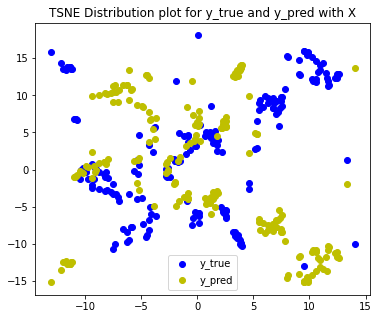

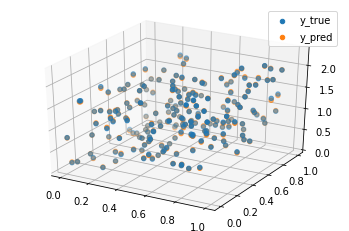

In [18]:
plot(x.numpy(), y.numpy(), y_pred.numpy())
plot_3d(x.numpy(), y[:, 1].numpy(), y_pred=y_pred[:, 1].numpy())